In [147]:
import importlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
import os
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from main.utils import data_manage_utils, train_utils

importlib.reload(train_utils)
importlib.reload(data_manage_utils)

loading_folder = "2024_06_17-1513"
loading_spec = "XGB"

ROOT_PATH = os.path.abspath("../../")
TRAIN_DATA_FOLDER = os.path.join(ROOT_PATH, "data/training/training_results/", loading_spec, loading_folder)

pert_result_df_path = os.path.join(TRAIN_DATA_FOLDER,"pert_test_results_df.pkl.gz")
pert_results_df = pd.read_pickle(pert_result_df_path, compression="gzip")

pert_results_df

,y_true,y,pert_alarm,y_outcomes,changed_to,corrected,worsened,correct,y_corrected,y_forced_mistake,y_forced_correction
idx,,,,,,,,,,,
10001243,1,1,False,{1},{},0.0,0.000000,True,1,1,1
10003947,1,1,False,{1},{},0.0,0.000000,True,1,1,1
10004727,1,1,False,{1},{},0.0,0.000000,True,1,1,1
10006126,1,1,False,{1},{},0.0,0.000000,True,1,1,1
10006791,1,1,False,{1},{},0.0,0.000000,True,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
9998396,0,0,False,{0},{},0.0,0.000000,True,0,0,0
9998430,2,2,False,{2},{},0.0,0.000000,True,2,2,2
9998460,1,1,False,{1},{},0.0,0.000000,True,1,1,1


In [148]:
alarmed_cases = pert_results_df[pert_results_df["pert_alarm"] == True]
alarmed_cases

,y_true,y,pert_alarm,y_outcomes,changed_to,corrected,worsened,correct,y_corrected,y_forced_mistake,y_forced_correction
idx,,,,,,,,,,,
10007456,2,1,True,"{1, 2}",{2},0.032258,0.000000,False,2,1,1
10007538,0,1,True,"{0, 1}",{0},0.032258,0.000000,False,0,1,1
10007606,0,1,True,"{0, 1}",{0},0.258065,0.000000,False,0,1,1
10007615,1,2,True,"{1, 2}",{1},0.225806,0.000000,False,1,2,2
10007943,1,1,True,"{1, 2}",{2},0.000000,0.032258,True,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
9998021,1,0,True,"{0, 2}",{2},0.000000,0.000000,False,1,0,0
9998039,0,0,True,"{0, 1}",{1},0.000000,0.032258,True,0,0,0
9998053,0,1,True,"{1, 2}",{2},0.000000,0.000000,False,0,1,1


In [149]:
unmarked_cases = pert_results_df[pert_results_df["pert_alarm"] == False]
unmarked_cases

,y_true,y,pert_alarm,y_outcomes,changed_to,corrected,worsened,correct,y_corrected,y_forced_mistake,y_forced_correction
idx,,,,,,,,,,,
10001243,1,1,False,{1},{},0.0,0.0,True,1,1,1
10003947,1,1,False,{1},{},0.0,0.0,True,1,1,1
10004727,1,1,False,{1},{},0.0,0.0,True,1,1,1
10006126,1,1,False,{1},{},0.0,0.0,True,1,1,1
10006791,1,1,False,{1},{},0.0,0.0,True,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
9998376,1,1,False,{1},{},0.0,0.0,True,1,1,1
9998396,0,0,False,{0},{},0.0,0.0,True,0,0,0
9998430,2,2,False,{2},{},0.0,0.0,True,2,2,2


In [173]:
def calc_random_acc_batch(df : pd.DataFrame, sample_size = 100, n_samples = 1000):
    ret = []
    random_seeds = range(0,n_samples,1)
    for counter in range(0,n_samples,1):
        subset = df.sample(n=sample_size, replace=False, weights=None, random_state=random_seeds[counter])
        acc = accuracy_score(subset["y_true"], subset["y"])
        ret.append(acc)
    return np.array(ret)

def print_stats(arr : np.ndarray, name):
    print(f"{name}:")
    print(f"\tMean: \t{arr.mean()}")
    print(f"\tStd: \t{arr.std()}")

def calculate_n_bins(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    bin_width = 2 * iqr / len(data)**(1/3)
    num_bins = int(np.ceil((data.max() - data.min()) / bin_width))
    return num_bins

0.57

Unmarked:
	Mean: 	0.8014366666666668
	Std: 	0.03930100917562069
Alarmed:
	Mean: 	0.5588266666666667
	Std: 	0.04912253341277187


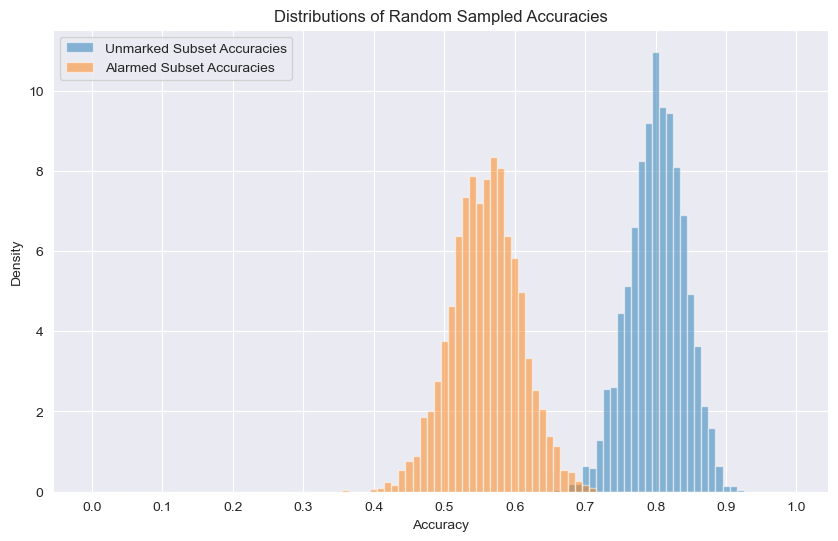

In [183]:
unmarked_accuracies = calc_random_acc_batch(unmarked_cases, sample_size=100, n_samples=3000)
alarmed_accuracies = calc_random_acc_batch(alarmed_cases, sample_size=100, n_samples=3000)
all_accuracies = calc_random_acc_batch(pert_results_df, sample_size=100, n_samples=3000)

bins = np.arange(-0.005, 1.005, 0.01)
x_ticks = np.arange(0, 1.1, 0.1)
# Plot the distributions
plt.figure(figsize=(10, 6))
plt.hist(unmarked_accuracies, alpha=0.5, bins=bins, label='Unmarked Subset Accuracies', density=True)
plt.hist(alarmed_accuracies, alpha=0.5, bins=bins, label='Alarmed Subset Accuracies', density=True)
#plt.hist(all_accuracies,bins=n,alpha=0.5, label='Whole Dataset Accuracies', density=True)

# Add labels, title, and legend
plt.xlabel('Accuracy')
plt.ylabel('Density')
plt.title('Distributions of Random Sampled Accuracies')
plt.xticks(x_ticks)
print_stats(unmarked_accuracies, name="Unmarked")
print_stats(alarmed_accuracies, name="Alarmed")

plt.legend()

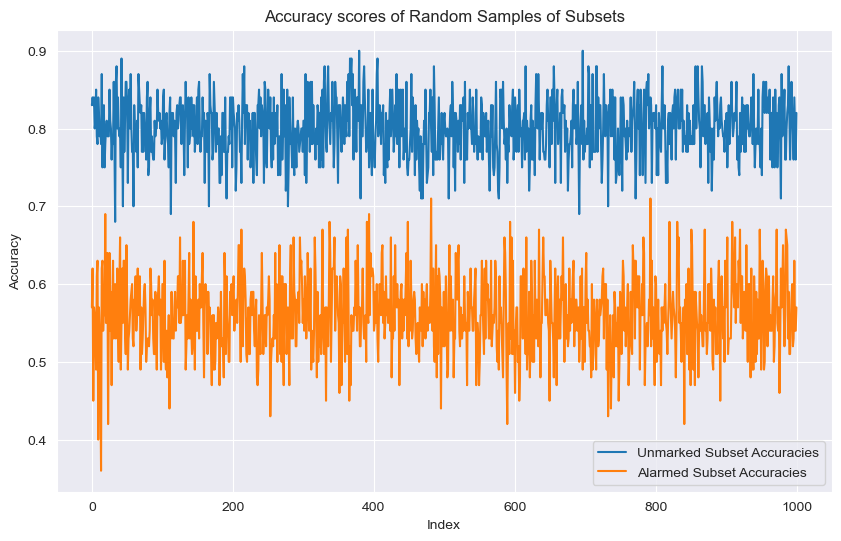

In [152]:
# Plot the distributions
plt.figure(figsize=(10, 6))
plt.plot(unmarked_accuracies, label='Unmarked Subset Accuracies')
plt.plot(alarmed_accuracies, label='Alarmed Subset Accuracies')
#plt.plot(all_accuracies, label='Whole Dataset Accuracies')

# Add labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Accuracy')
plt.title('Accuracy scores of Random Samples of Subsets')
plt.legend()

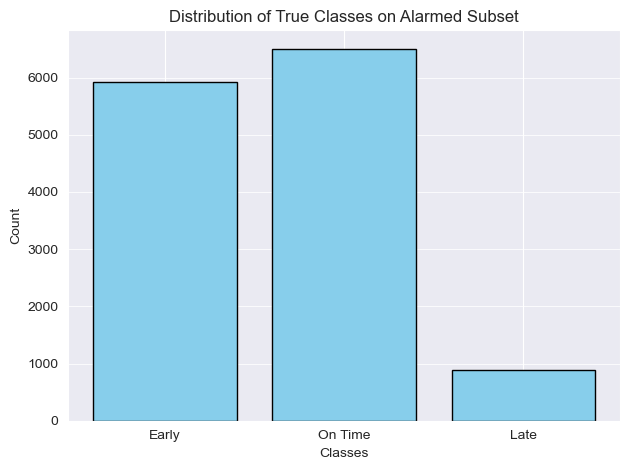

In [157]:
def plot_bar_distribution(series: pd.Series, title):
    # Plot the distributions
    plt.figure()
    
    # Define labels for the classes
    labels = ["Early", "On Time", "Late"]
    
    # Count the occurrences of each class
    class_counts = series.value_counts().sort_index()
    
    plt.bar(labels, class_counts, color="skyblue", edgecolor="black")
    
    # Add labels, title, and legend
    plt.xlabel("Classes")
    plt.ylabel('Count')
    plt.title(title)
    plt.grid(axis="y", alpha=0.8)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

plot_bar_distribution(alarmed_cases["y_true"], title='Distribution of True Classes on Alarmed Subset')

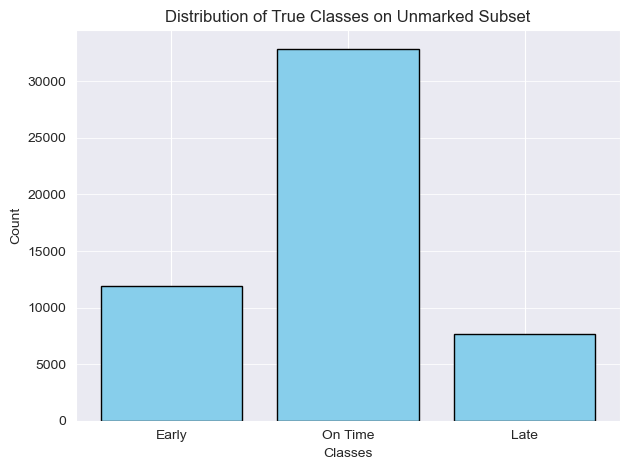

In [163]:
plot_bar_distribution(unmarked_cases["y_true"], title='Distribution of True Classes on Unmarked Subset')

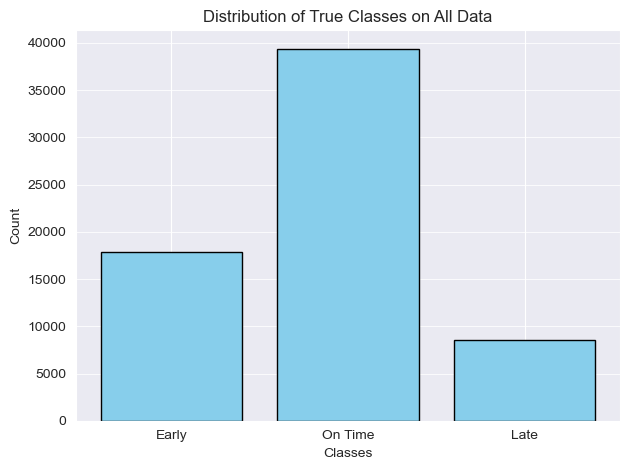

In [162]:
plot_bar_distribution(pert_results_df["y_true"], title='Distribution of True Classes on All Data')

In [186]:
# Test statistics:
alarmed_acc = accuracy_score(alarmed_cases["y_true"], alarmed_cases["y"])
unmarked_acc = accuracy_score(unmarked_cases["y_true"], unmarked_cases["y"])
all_acc = accuracy_score(pert_results_df["y_true"], pert_results_df["y"])

In [194]:
import scipy.stats as stats
stats.ttest_rel(alarmed_accuracies, unmarked_accuracies)

Ttest_relResult(statistic=-212.5363857900253, pvalue=0.0)